Goal: get the best fit acheiveable with just a 2 + 1 dimension linear regression
General strategy: use categorical features to reduce dimensionality and create groups or nodes that share the most in common, then fit a 2d multiple linear regression on these groupings generating an N number of 3d regression fit plots 

General strategy: 

PCA to reduce dimensionality of categorical values ==> kMeans classifier to assign observations into groups ==> MLR to fit 2 numerical dimensions(probably feature engineered) 

In [304]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as mn #missingno had to be installed 'pip install missingno' 
import math
import matplotlib.pyplot as plt
%matplotlib inline 


# Loading Data, Str/Int Split

In [305]:
train = pd.read_csv('train.csv')

In [306]:
intCols = train.columns[(train.dtypes == 'int64')| (train.dtypes == 'float64')]
strCols = train.columns[train.dtypes == 'object']

In [307]:
dfInt = train[intCols]
dfStr = train[strCols]
print(dfInt.shape, dfStr.shape)

(1460, 38) (1460, 43)


In [309]:
dfStr.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [251]:
# setting up the y target variable (log10(SalePrice))
target = dfInt.SalePrice.apply(math.log10)
# drop SalePrice from dfInt
dfInt = dfInt.drop(['SalePrice','Id'], axis = 1)
target.shape

(1460,)

In [252]:
target = pd.DataFrame(target)
target

SalePrice
0      5.319106
1      5.258877
2      5.349278
3      5.146128
4      5.397940
5      5.155336
6      5.487138
7      5.301030
8      5.113609
9      5.071882
10     5.112270
11     5.537819
12     5.158362
13     5.446382
14     5.195900
15     5.120574
16     5.173186
17     4.954243
18     5.201397
19     5.143015
20     5.512284
21     5.144263
22     5.361728
23     5.113609
24     5.187521
25     5.408749
26     5.129690
27     5.485721
28     5.317018
29     4.835691
...         ...
1430   5.283618
1431   5.157608
1432   4.809560
1433   5.270679
1434   5.204120
1435   5.240549
1436   5.080987
1437   5.596176
1438   5.175222
1439   5.294466
1440   5.281033
1441   5.174060
1442   5.491362
1443   5.082785
1444   5.254306
1445   5.110590
1446   5.198382
1447   5.380211
1448   5.049218
1449   4.963788
1450   5.133539
1451   5.458018
1452   5.161368
1453   4.926857
1454   5.267172
1455   5.243038
1456   5.322219
1457   5.425697
1458   5.152670
1459   5.168792

[1460 rows x 1 columns]

# Categorical transform 

In [253]:
#using Class shared on the git repo 
class NumericDataFrame():
    """
    This class converts categorical types of a dataframe into numeric types.
    It also automatically imputes missing values as the row mean.
    """
    def __init__(self, df):
        self.type_objs = df.select_dtypes(exclude=['float64',"int64"])
        self.type_numeric = df.select_dtypes(include=['float64',"int64"])
        self.transform_dict = self.get_transform_dict()
        
    def impute(self, df):
        df = df.apply(lambda x: x.fillna(1),axis=0)
        return df

    def get_transform_dict(self):
        transform_dict = {}
        for col in self.type_objs.columns:
            cats = pd.Categorical(self.type_objs[col]).categories
            d = {}
            for i, cat in enumerate(cats):
                d[cat] = i + 2
            transform_dict[col] = d
        return transform_dict

    def __call__(self):
        df = self.type_objs
        df.replace(self.transform_dict, inplace=True)
        df = pd.merge(self.type_numeric, df, left_index=True, right_index=True)
        df = self.impute(df)
        return df

In [254]:
CatNum = NumericDataFrame(dfStr)()
#normalized version
CatNumNorm=(CatNum-CatNum.min())/(CatNum.max()-CatNum.min())
CatNumNorm

MSZoning  Street  Alley  LotShape  LandContour  Utilities  LotConfig  \
0         0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1         0.75     1.0    0.0  1.000000     1.000000        0.0       0.50   
2         0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
3         0.75     1.0    0.0  0.000000     1.000000        0.0       0.00   
4         0.75     1.0    0.0  0.000000     1.000000        0.0       0.50   
5         0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
6         0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
7         0.75     1.0    0.0  0.000000     1.000000        0.0       0.00   
8         1.00     1.0    0.0  1.000000     1.000000        0.0       1.00   
9         0.75     1.0    0.0  1.000000     1.000000        0.0       0.00   
10        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
11        0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
12        0.75     1.0    0.0  0.333333     1.000000        0.0       1.00   
13        0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
14        0.75     1.0    0.0  0.000000     1.000000        0.0       0.00   
15        1.00     1.0    0.0  1.000000     1.000000        0.0       0.00   
16        0.75     1.0    0.0  0.000000     1.000000        0.0       0.25   
17        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
18        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
19        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
20        0.75     1.0    0.0  0.000000     1.000000        0.0       0.00   
21        1.00     1.0    0.5  1.000000     0.000000        0.0       1.00   
22        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
23        1.00     1.0    0.0  1.000000     1.000000        0.0       1.00   
24        0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
25        0.75     1.0    0.0  1.000000     1.000000        0.0       0.00   
26        0.75     1.0    0.0  1.000000     1.000000        0.0       0.00   
27        0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
28        0.75     1.0    0.0  0.000000     1.000000        0.0       0.25   
29        1.00     1.0    0.0  0.000000     1.000000        0.0       1.00   
...        ...     ...    ...       ...          ...        ...        ...   
1430      0.75     1.0    0.0  0.666667     1.000000        0.0       1.00   
1431      0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
1432      0.75     1.0    0.5  1.000000     1.000000        0.0       1.00   
1433      0.75     1.0    0.0  0.000000     1.000000        0.0       1.00   
1434      0.75     1.0    0.0  1.000000     0.666667        0.0       1.00   
1435      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1436      0.75     1.0    0.0  1.000000     1.000000        0.0       0.50   
1437      0.75     1.0    0.0  1.000000     1.000000        0.0       0.50   
1438      1.00     1.0    0.0  1.000000     1.000000        0.0       1.00   
1439      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1440      0.75     1.0    0.0  0.000000     0.000000        0.0       1.00   
1441      1.00     1.0    0.0  1.000000     1.000000        0.0       1.00   
1442      0.25     1.0    0.0  1.000000     1.000000        0.0       1.00   
1443      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1444      0.75     1.0    0.0  1.000000     1.000000        0.0       0.50   
1445      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1446      0.75     1.0    0.0  0.000000     1.000000        0.0       0.25   
1447      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1448      0.75     1.0    0.0  1.000000     1.000000        0.0       1.00   
1449      1.00     1.0    0.

In [310]:
# impute missingness in dfInt
from sklearn.preprocessing import Imputer

fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
dfInt = pd.DataFrame(fill_NaN.fit_transform(dfInt))

CatNumNorm.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

# PCA experiments

In [313]:
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D



pca = decomposition.PCA(n_components=3)
pca.fit(CatNumNorm)
X = pca.transform(CatNumNorm)
CatNumNorm.columns
pca.n_components

3

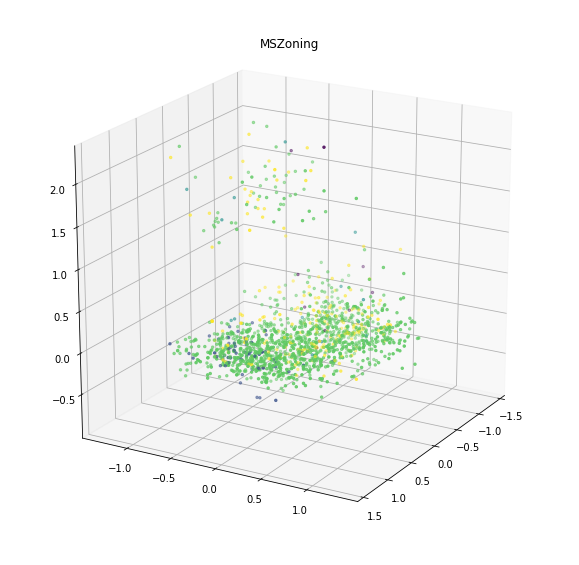

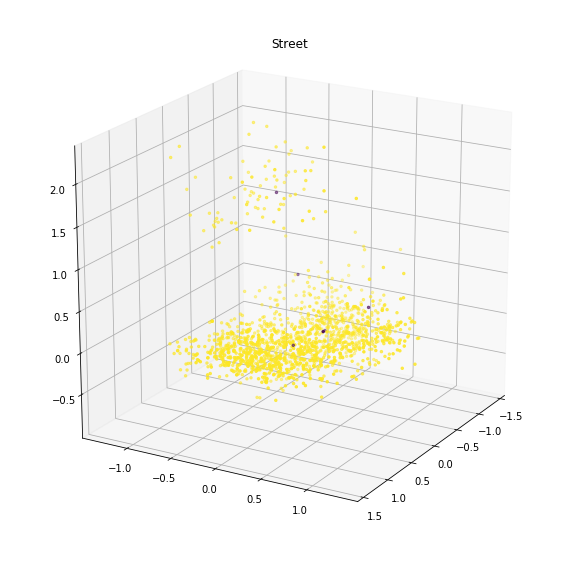

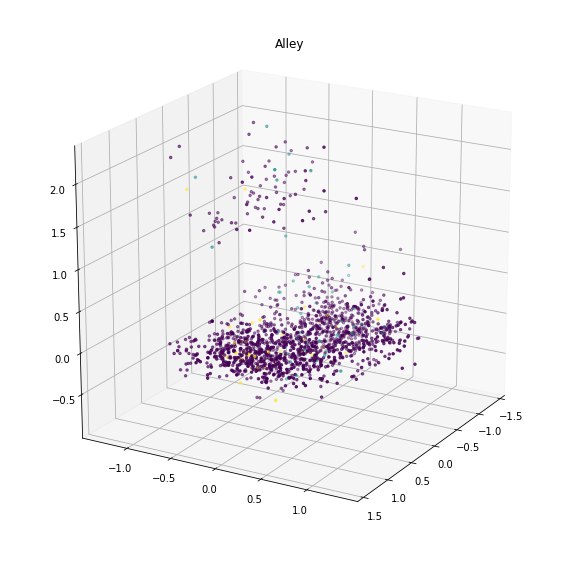

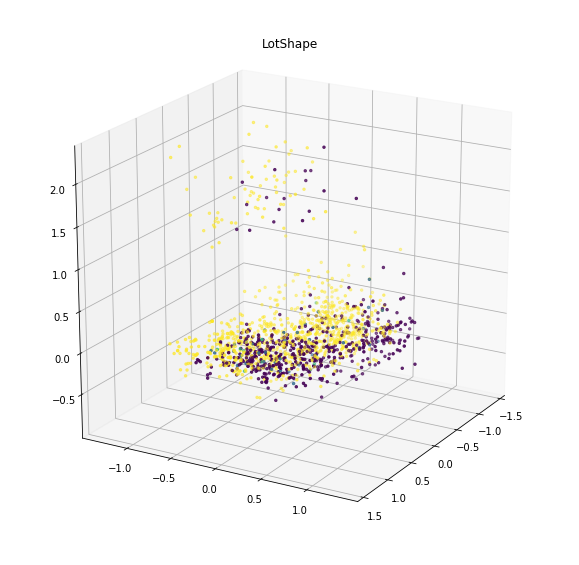

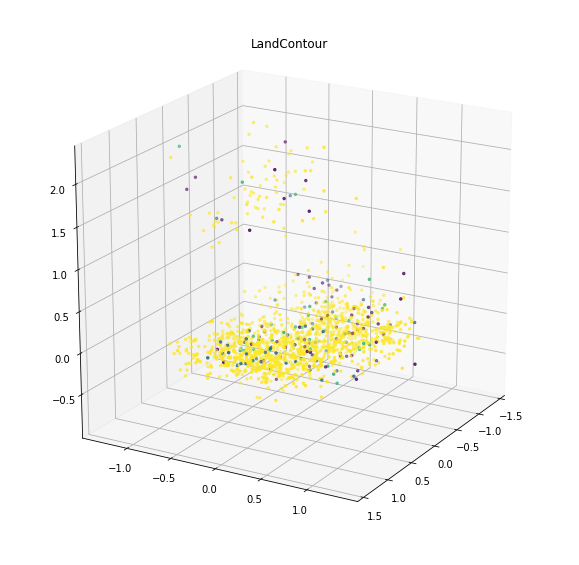

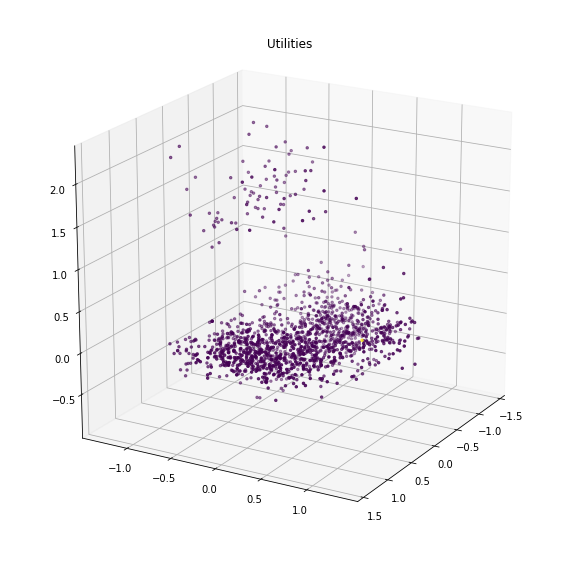

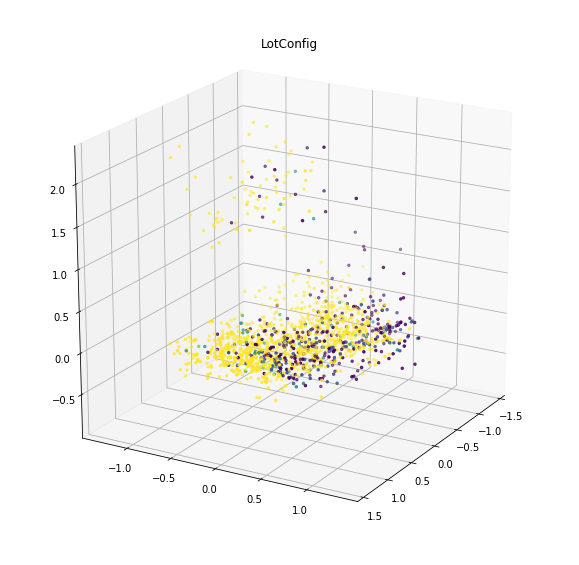

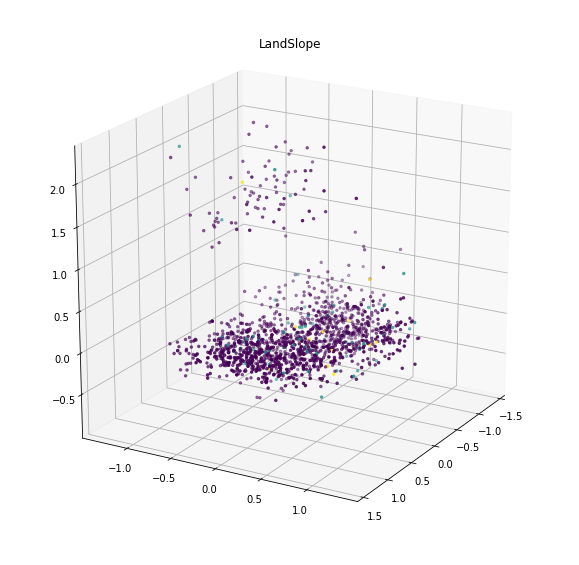

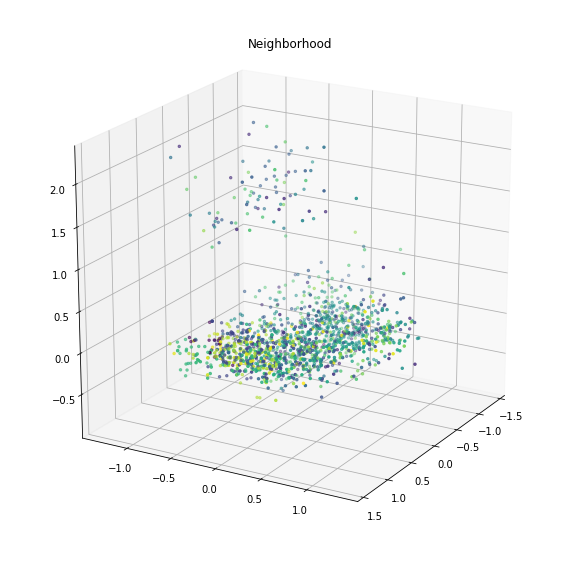

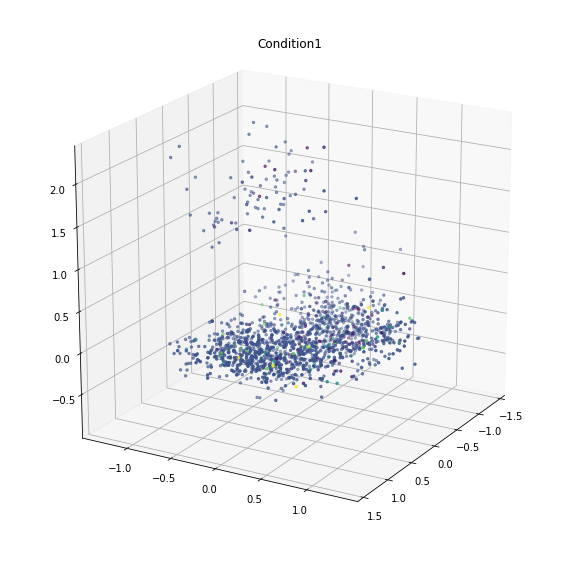

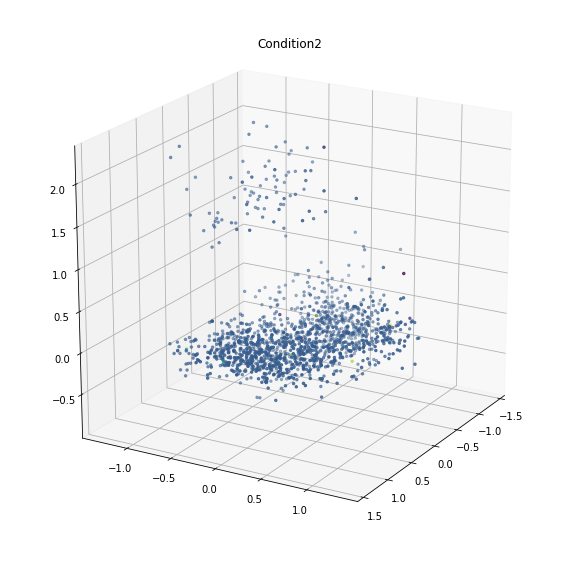

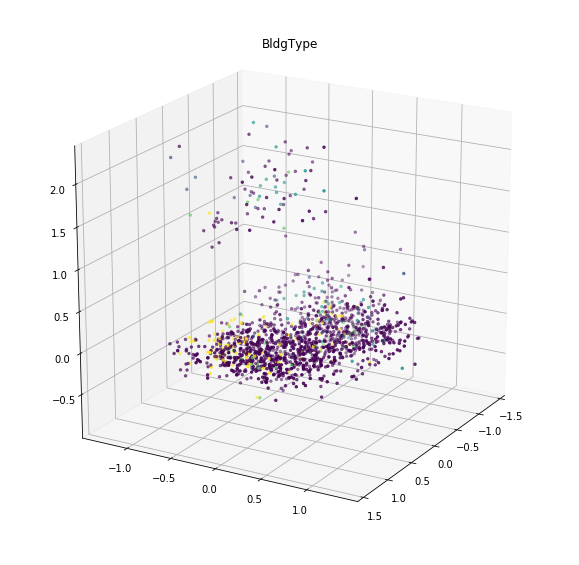

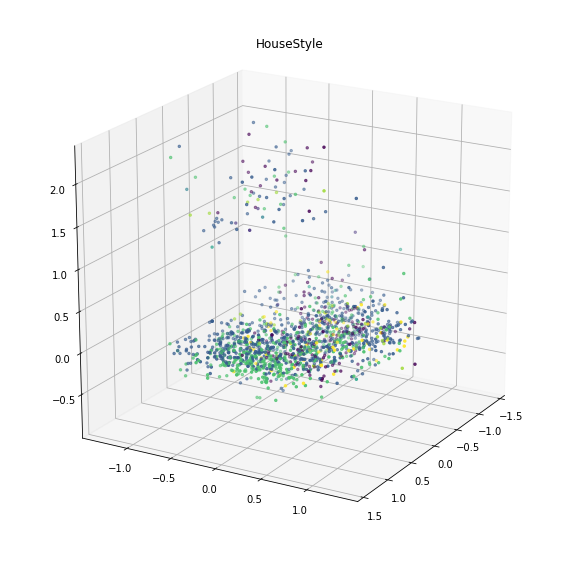

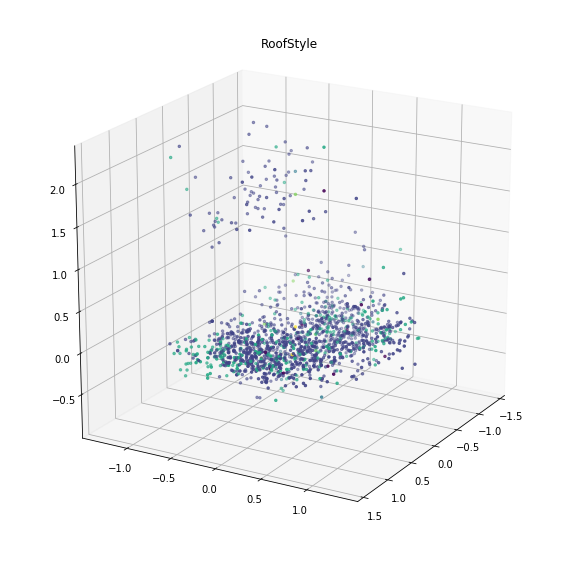

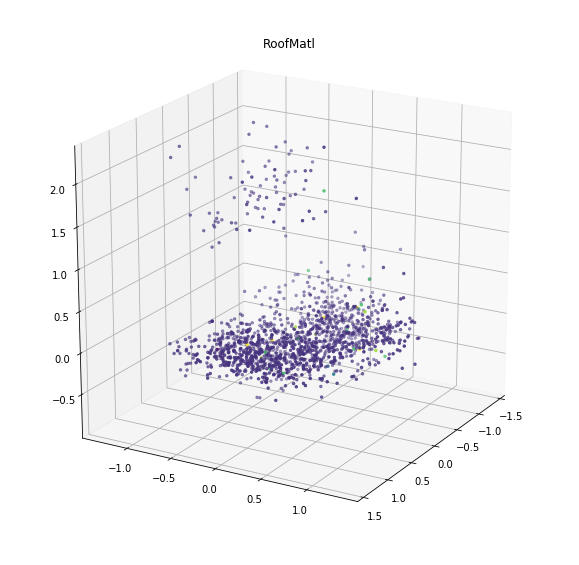

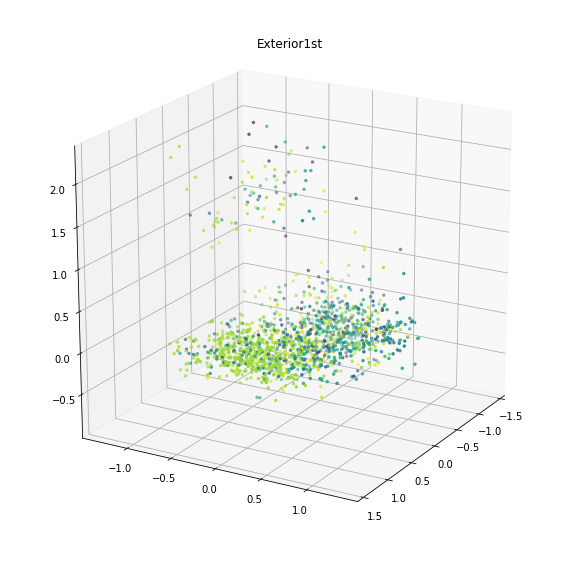

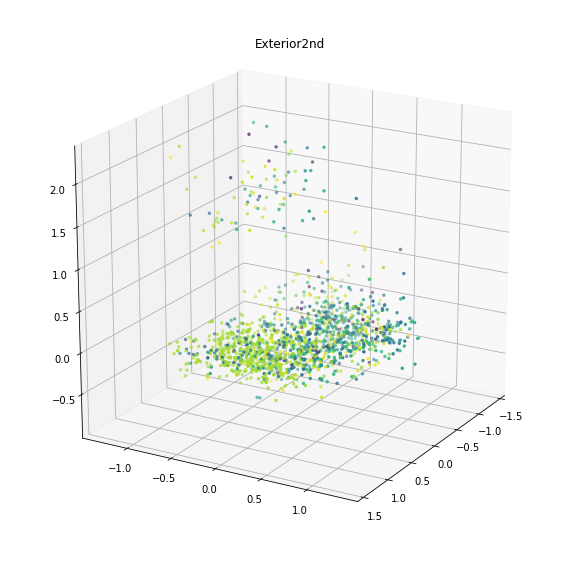

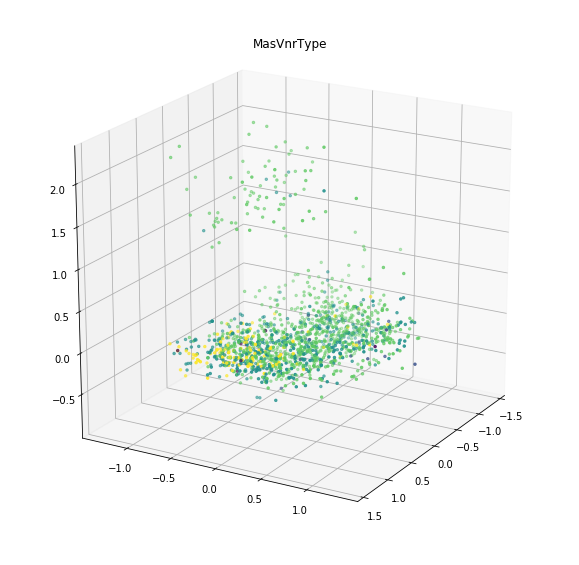

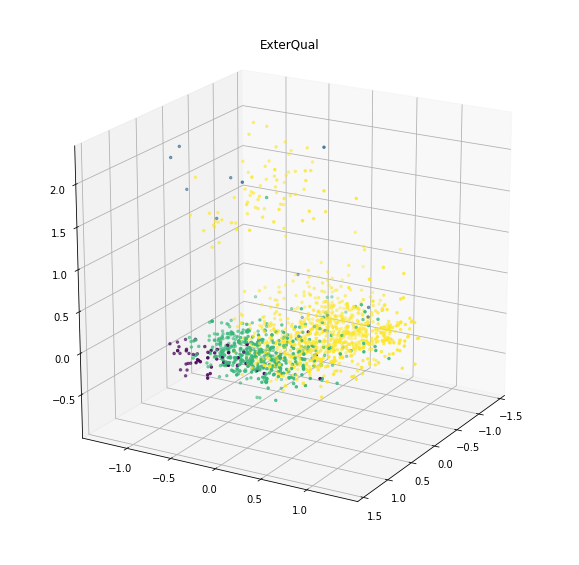

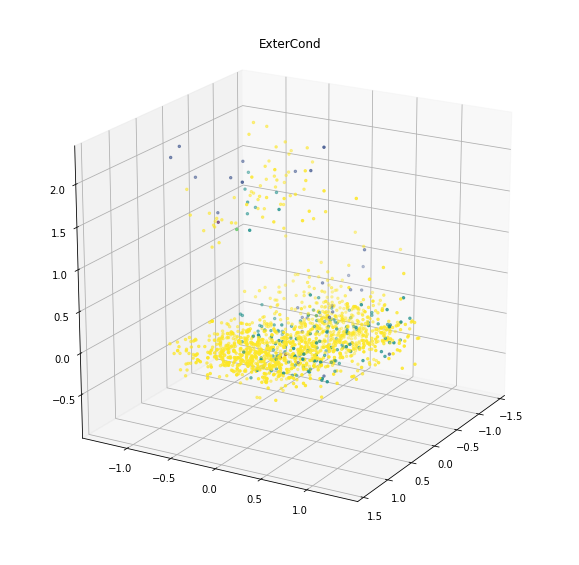

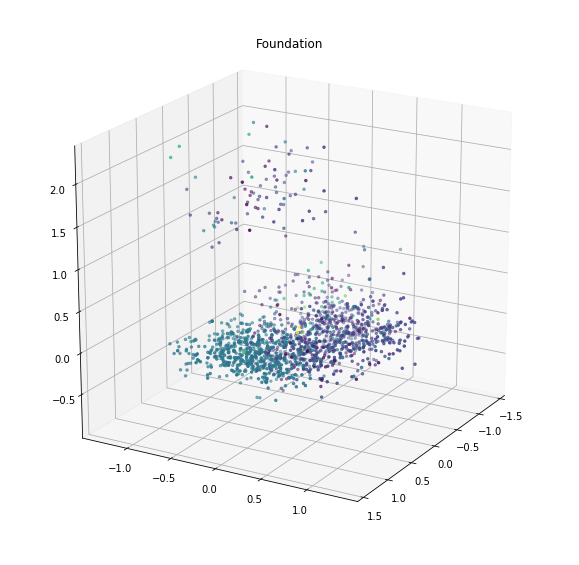

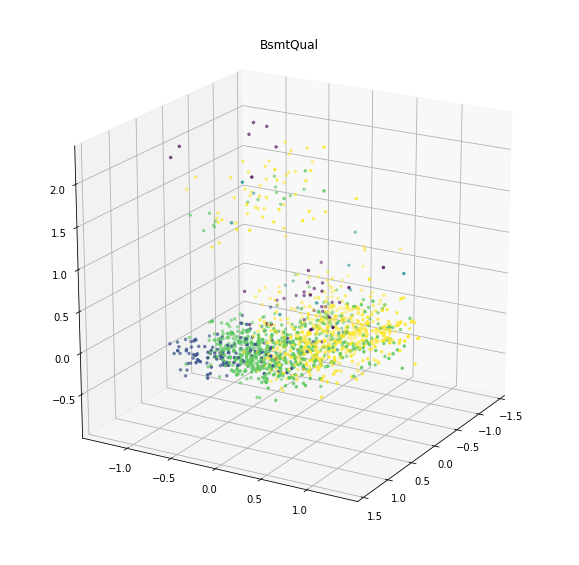

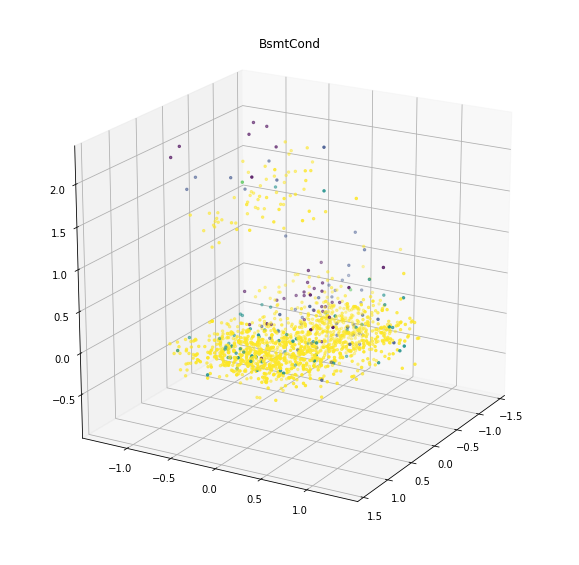

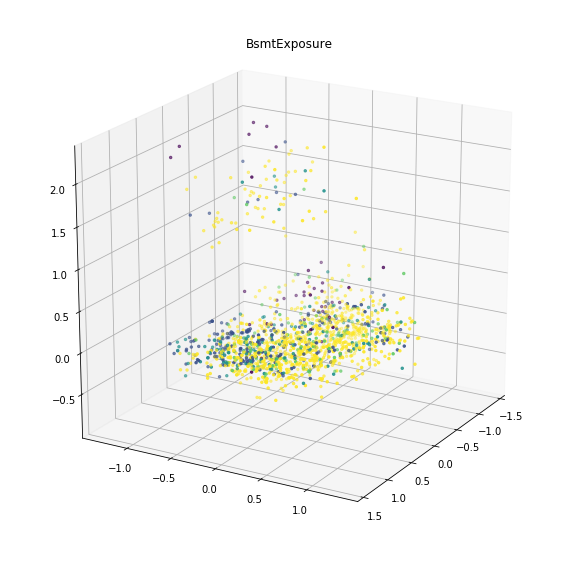

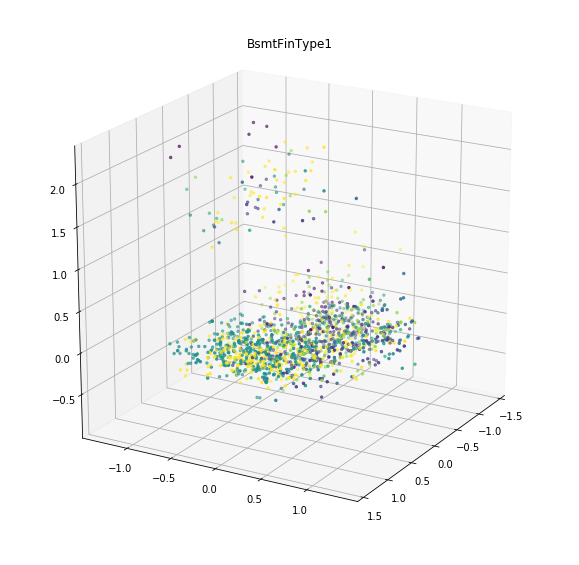

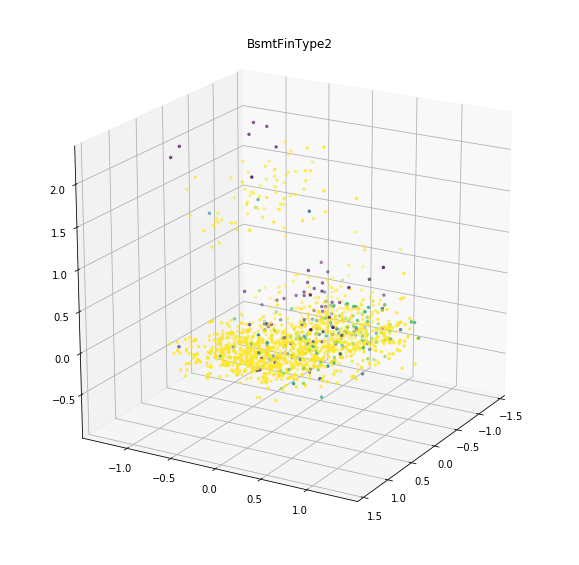

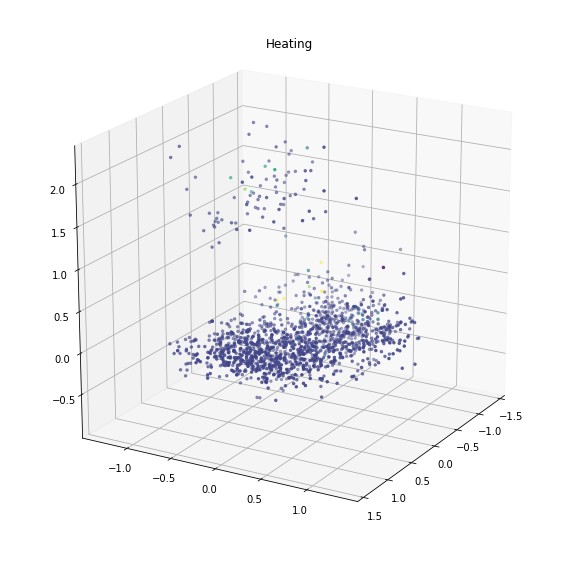

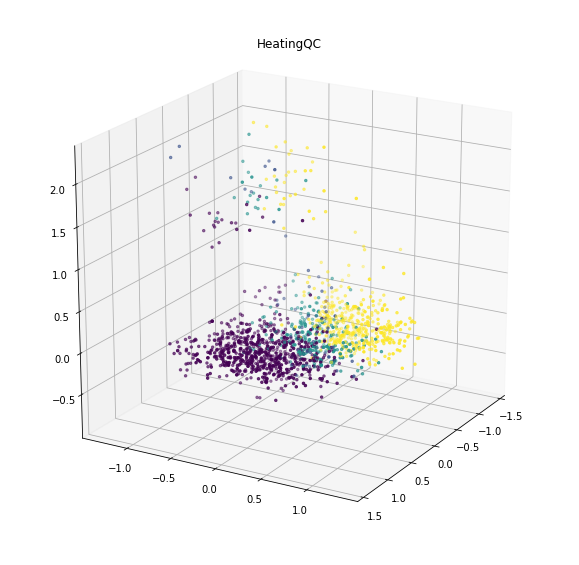

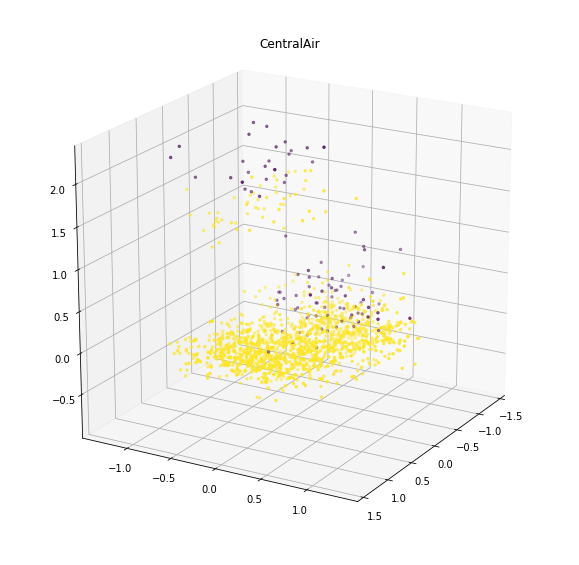

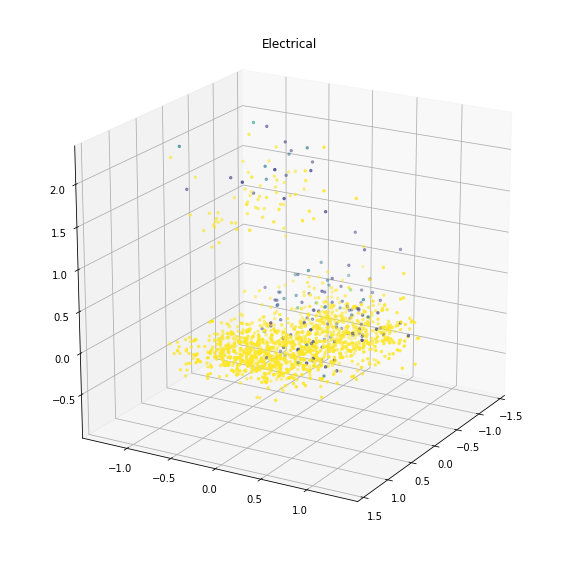

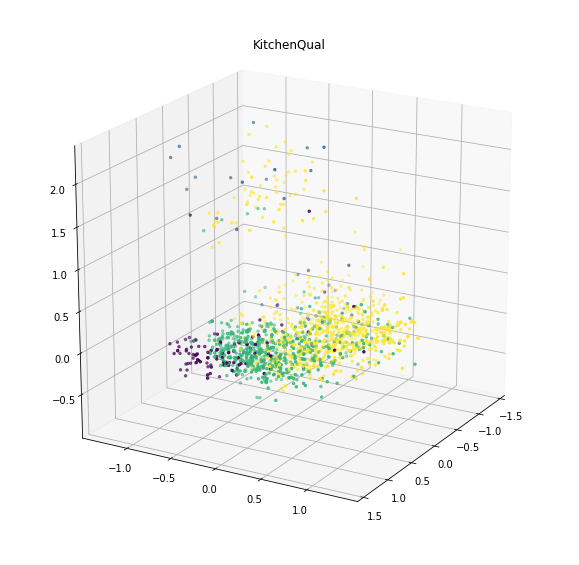

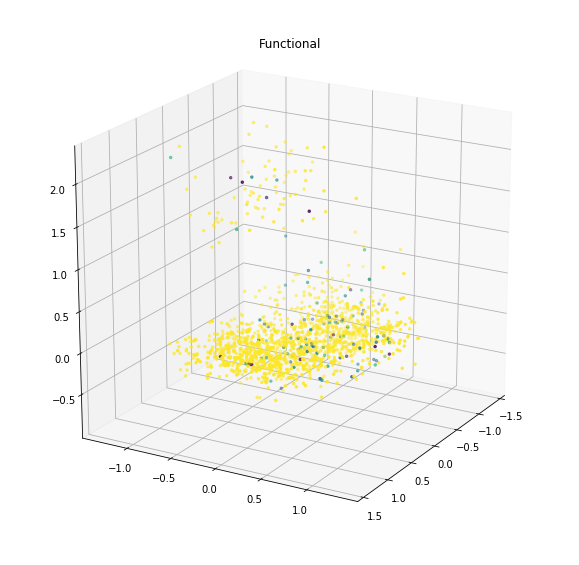

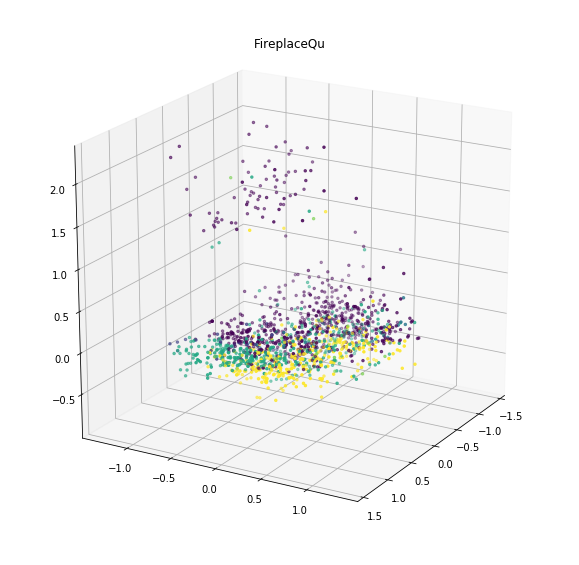

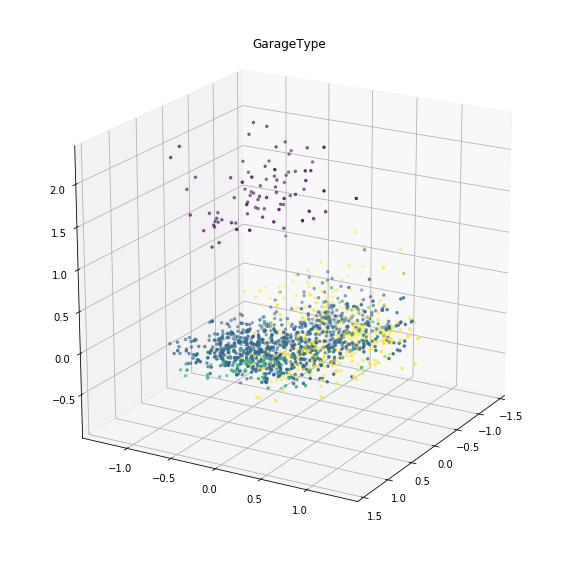

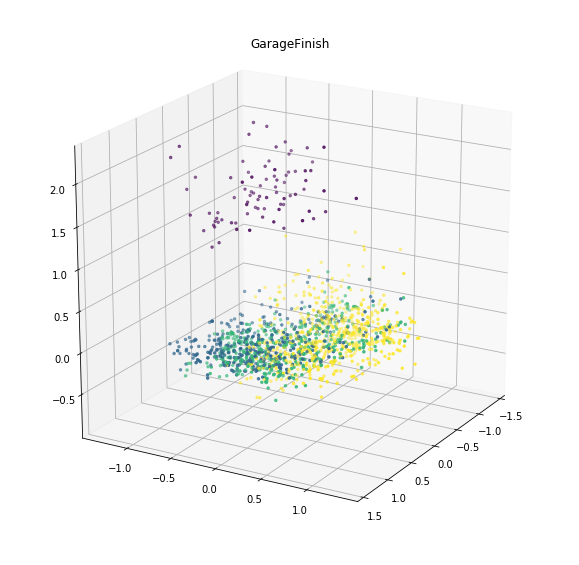

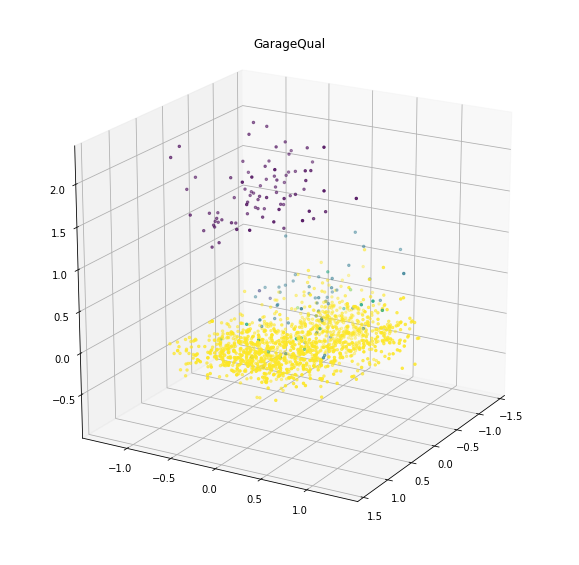

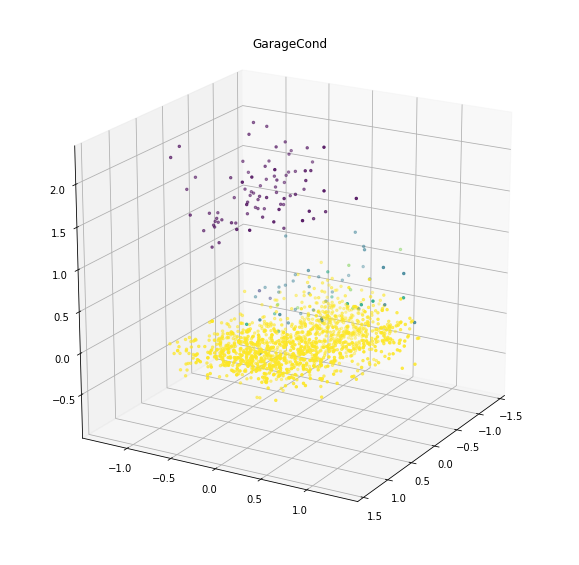

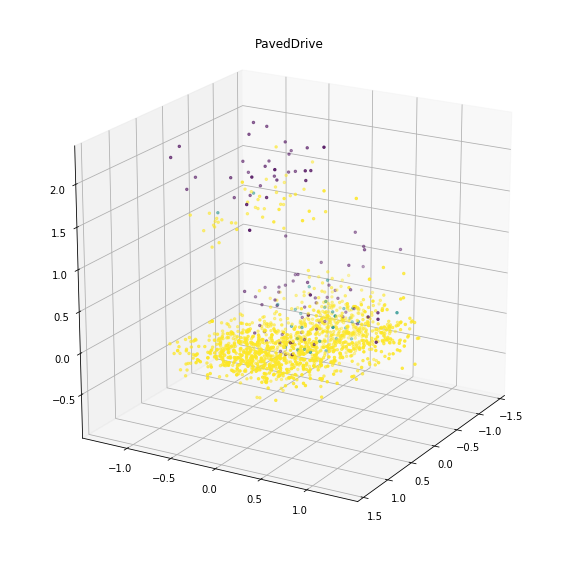

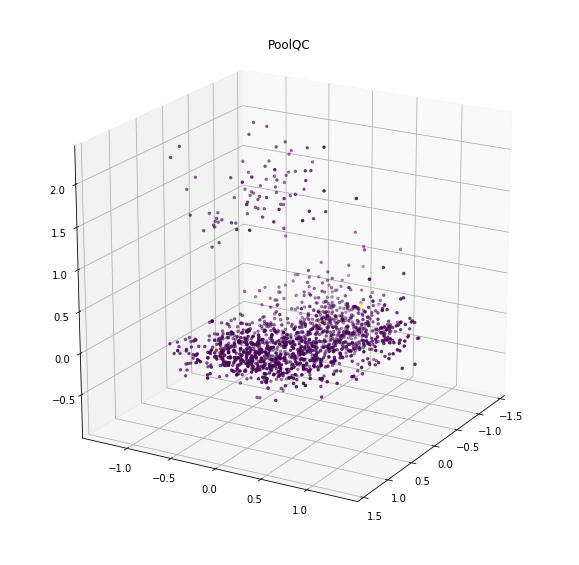

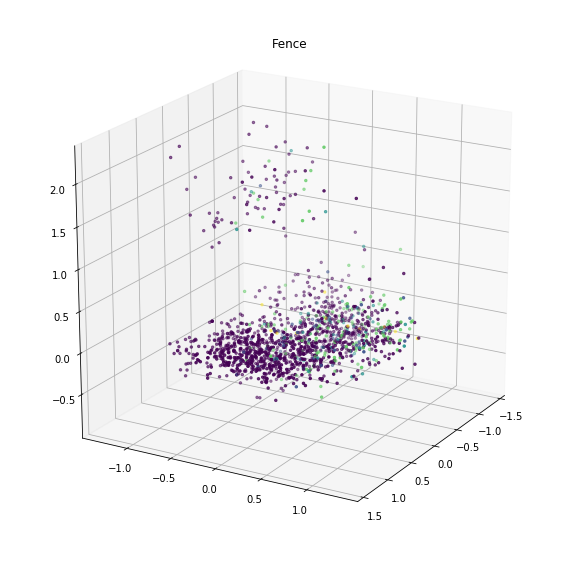

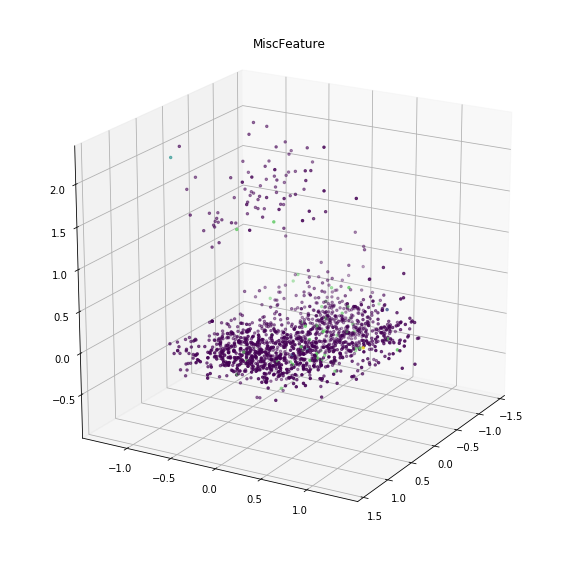

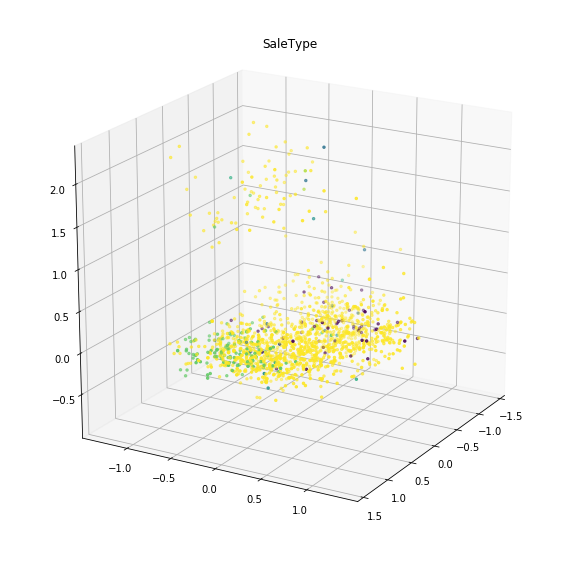

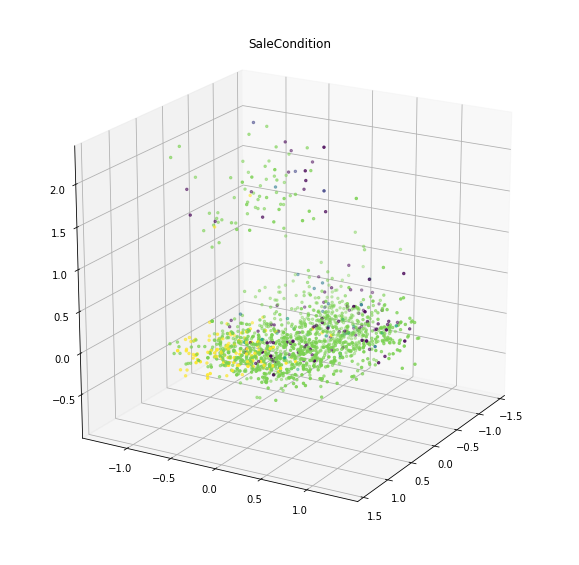

In [329]:


for each in CatNumNorm.columns:
    fig = plt.figure(figsize = [10,10])
    color = CatNumNorm[each]
    

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], c=color, s=6)
    plt.viridis()
    plt.title(each)

    ax.view_init(20, 30) # change these params to rotate cube
    plt.show()


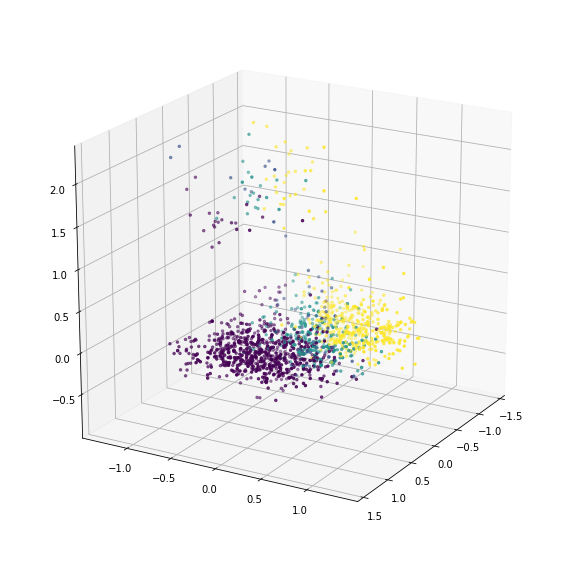

In [328]:
fig = plt.figure(figsize = [10,10])
color = CatNumNorm.HeatingQC
    

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=color, s=6)
plt.viridis()


ax.view_init(20, 30) # change these params to rotate cube
plt.show()

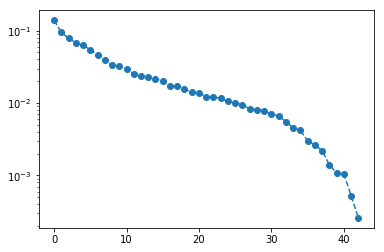

In [314]:

pca_trafo = decomposition.PCA().fit(CatNumNorm)

plt.semilogy(pca_trafo.explained_variance_ratio_, '--o')

In [86]:
pca_trafo.explained_variance_ratio_

array([ 0.13924304,  0.09481077,  0.07864358,  0.06827748,  0.0627666 ,
        0.05433367,  0.04633688,  0.03927749,  0.033437  ,  0.03202466,
        0.02928686,  0.0255943 ,  0.02342274,  0.02257379,  0.02166815,
        0.02002328,  0.01733779,  0.01710398,  0.01564015,  0.01403145,
        0.01384703,  0.01221607,  0.01207279,  0.01158276,  0.01052343,
        0.01010911,  0.00948765,  0.00828035,  0.00812986,  0.00778145,
        0.00710536,  0.00660489,  0.00554524,  0.00449308,  0.00422015,
        0.00300525,  0.00263652,  0.00219936,  0.00140544,  0.0010871 ,
        0.00105249,  0.00052166,  0.00025932])

# trying ANOVA to prune features instead 

In [110]:
from sklearn import feature_selection


anova = feature_selection.SelectPercentile(feature_selection.f_regression)
select = anova.fit(CatNum, target)
SelectPercentile

sklearn.feature_selection.univariate_selection.SelectPercentile

In [161]:
ANOVAscores = pd.DataFrame(list(zip(CatNum.columns, select.scores_, select.pvalues_)),\
                        columns = ['feature', 'score', 'p_value'])
ANOVAscores.sort_values('score', ascending = False)

feature       score        p_value
18      ExterQual  747.460342  3.331530e-133
30    KitchenQual  582.783253  1.344928e-108
32    FireplaceQu  330.847346   8.679038e-67
27      HeatingQC  323.080659   2.090454e-65
20     Foundation  298.229013   6.069300e-61
21       BsmtQual  239.134491   4.568886e-50
36     GarageCond  230.976251   1.555354e-48
35     GarageQual  208.494695   2.840871e-44
28     CentralAir  205.666987   9.855628e-44
37     PavedDrive  149.204041   9.699221e-33
29     Electrical  136.300855   3.600796e-30
3        LotShape  122.204537   2.452204e-27
34   GarageFinish  106.747712   3.375821e-24
42  SaleCondition   96.223494   4.848670e-22
33     GarageType   89.576537   1.139802e-20
12     HouseStyle   70.467295   1.093130e-16
8    Neighborhood   61.821267   7.261916e-15
22       BsmtCond   57.301006   6.598099e-14
39          Fence   56.290812   1.081801e-13
0        MSZoning   53.927790   3.445444e-13
13      RoofStyle   52.783747   6.042725e-13
23   BsmtExposure   37.943677   9.400183e-10
25   BsmtFinType2   36.435359   1.998417e-09
19      ExterCond   32.904798   1.174966e-08
26        Heating   29.113631   7.955380e-08
31     Functional   25.603103   4.726788e-07
16    Exterior2nd   23.439305   1.426260e-06
15    Exterior1st   22.021470   2.949187e-06
9      Condition1   19.850164   9.015211e-06
14       RoofMatl   17.051900   3.843499e-05
2           Alley   12.213737   4.885952e-04
40    MiscFeature    7.989115   4.770166e-03
6       LotConfig    7.786910   5.331174e-03
11       BldgType    7.716543   5.541831e-03
1          Street    4.814455   2.837931e-02
38         PoolQC    3.104202   7.830004e-02
7       LandSlope    2.167258   1.411932e-01
41       SaleType    1.971412   1.605111e-01
17     MasVnrType    1.701394   1.923117e-01
4     LandContour    1.526504   2.168369e-01
24   BsmtFinType1    0.712611   3.987170e-01
5       Utilities    0.232689   6.296094e-01
10     Condition2    0.002568   9.595914e-01

In [117]:
FeatCut = list(ANOVAscores.feature.iloc[0:3])

In [120]:
CutCatNorm = CatNumNorm[FeatCut]

# feed into kmeans classifier

In [143]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4)
kmeans.fit(CutCatNorm)
labels = kmeans.labels_
kmeans.score(CutCatNorm)

-20.590262962242605

In [186]:
target.shape

(1460,)

In [231]:
from sklearn.linear_model import LinearRegression

def twoLayer(n_nodes, dataCat, dataNum, tar):
    #firstlayer: k-means classifier groups into different nodes 
    #dummies = pd.get_dummies(dataCat)
    kmeans = KMeans(n_clusters = n_nodes, random_state = 10)
    kmeans.fit(dataCat)
    labels = kmeans.labels_
    #connection: modifying numeric dataframe with new groups
    
    dataNum['group'] = labels
    tar['group'] = labels
    #set up Lin regressor 
    lin = LinearRegression()
    # doing lasso and giving score for each group
    for n in range(0, n_nodes):
        X = dataNum[dataNum['group'] == n]
        y = tar[tar['group'] == n]
        X = X.iloc[:,-1]
        y = y.iloc[:,0]
        lin.fit(X,y)
        print(lin.score(X,y))

In [232]:
twoLayer(1, CutCatNorm, dfInt, target)

ValueError: Expected 2D array, got 1D array instead:
array=[0 0 0 ..., 0 0 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [236]:
dfInt

0      1            2        3     4    5       6       7      8  \
0        1.0   60.0    65.000000   8450.0   7.0  5.0  2003.0  2003.0  196.0   
1        2.0   20.0    80.000000   9600.0   6.0  8.0  1976.0  1976.0    0.0   
2        3.0   60.0    68.000000  11250.0   7.0  5.0  2001.0  2002.0  162.0   
3        4.0   70.0    60.000000   9550.0   7.0  5.0  1915.0  1970.0    0.0   
4        5.0   60.0    84.000000  14260.0   8.0  5.0  2000.0  2000.0  350.0   
5        6.0   50.0    85.000000  14115.0   5.0  5.0  1993.0  1995.0    0.0   
6        7.0   20.0    75.000000  10084.0   8.0  5.0  2004.0  2005.0  186.0   
7        8.0   60.0   717.756757  10382.0   7.0  6.0  1973.0  1973.0  240.0   
8        9.0   50.0    51.000000   6120.0   7.0  5.0  1931.0  1950.0    0.0   
9       10.0  190.0    50.000000   7420.0   5.0  6.0  1939.0  1950.0    0.0   
10      11.0   20.0    70.000000  11200.0   5.0  5.0  1965.0  1965.0    0.0   
11      12.0   60.0    85.000000  11924.0   9.0  5.0  2005.0  2006.0  286.0   
12      13.0   20.0   682.216216  12968.0   5.0  6.0  1962.0  1962.0    0.0   
13      14.0   20.0    91.000000  10652.0   7.0  5.0  2006.0  2007.0  306.0   
14      15.0   20.0   671.297297  10920.0   6.0  5.0  1960.0  1960.0  212.0   
15      16.0   45.0    51.000000   6120.0   7.0  8.0  1929.0  2001.0    0.0   
16      17.0   20.0   664.972973  11241.0   6.0  7.0  1970.0  1970.0  180.0   
17      18.0   90.0    72.000000  10791.0   4.0  5.0  1967.0  1967.0    0.0   
18      19.0   20.0    66.000000  13695.0   5.0  5.0  2004.0  2004.0    0.0   
19      20.0   20.0    70.000000   7560.0   5.0  6.0  1958.0  1965.0    0.0   
20      21.0   60.0   101.000000  14215.0   8.0  5.0  2005.0  2006.0  380.0   
21      22.0   45.0    57.000000   7449.0   7.0  7.0  1930.0  1950.0    0.0   
22      23.0   20.0    75.000000   9742.0   8.0  5.0  2002.0  2002.0  281.0   
23      24.0  120.0    44.000000   4224.0   5.0  7.0  1976.0  1976.0    0.0   
24      25.0   20.0   575.054054   8246.0   5.0  8.0  1968.0  2001.0    0.0   
25      26.0   20.0   110.000000  14230.0   8.0  5.0  2007.0  2007.0  640.0   
26      27.0   20.0    60.000000   7200.0   5.0  7.0  1951.0  2000.0    0.0   
27      28.0   20.0    98.000000  11478.0   8.0  5.0  2007.0  2008.0  200.0   
28      29.0   20.0    47.000000  16321.0   5.0  6.0  1957.0  1997.0    0.0   
29      30.0   30.0    60.000000   6324.0   4.0  6.0  1927.0  1950.0    0.0   
...      ...    ...          ...      ...   ...  ...     ...     ...    ...   
1430  1431.0   60.0    60.000000  21930.0   5.0  5.0  2005.0  2005.0    0.0   
1431  1432.0  120.0   507.675676   4928.0   6.0  6.0  1976.0  1976.0    0.0   
1432  1433.0   30.0    60.000000  10800.0   4.0  6.0  1927.0  2007.0    0.0   
1433  1434.0   60.0    93.000000  10261.0   6.0  5.0  2000.0  2000.0  318.0   
1434  1435.0   20.0    80.000000  17400.0   5.0  5.0  1977.0  1977.0    0.0   
1435  1436.0   20.0    80.000000   8400.0   6.0  9.0  1962.0  2005.0  237.0   
1436  1437.0   20.0    60.000000   9000.0   4.0  6.0  1971.0  1971.0    0.0   
1437  1438.0   20.0    96.000000  12444.0   8.0  5.0  2008.0  2008.0  426.0   
1438  1439.0   20.0    90.000000   7407.0   6.0  7.0  1957.0  1996.0    0.0   
1439  1440.0   60.0    80.000000  11584.0   7.0  6.0  1979.0  1979.0   96.0   
1440  1441.0   70.0    79.000000  11526.0   6.0  7.0  1922.0  1994.0    0.0   
1441  1442.0  120.0   490.351351   4426.0   6.0  5.0  2004.0  2004.0  147.0   
1442  1443.0   60.0    85.000000  11003.0  10.0  5.0  2008.0  2008.0  160.0   
1443  1444.0   30.0   602.297297   8854.0   6.0  6.0  1916.0  1950.0    0.0   
1444  1445.0   20.0    63.000000   8500.0   7.0  5.0  2004.0  2004.0  106.0   
1445  1446.0   85.0    70.000000   8400.0   6.0  5.0  1966.0  1966.0    0.0   
1446  1447.0   20.0  1110.459459  26142.0   5.0  7.0  1962.0  1962.0  189.0   
1447  1448.0   60.0    80.000000  10000.0   8.0  5.0  1995.0  1996.0  438.0   
1448  1449.0   50.0    70.000000  11767.0   4.0  7.0  1910.0 